In [2]:
# Si ya las tienes, puedes saltarte esta celda.
%pip install pandas numpy pyarrow folium matplotlib seaborn boto3 python-dotenv

Note: you may need to restart the kernel to use updated packages.


In [3]:
import boto3
import os
from dotenv import load_dotenv

# == CONFIGURA TUS KEYS AQUÍ ===
load_dotenv()

AWS_ACCESS_KEY = os.getenv("AWS_ACCESS_KEY_ID")
AWS_SECRET_KEY = os.getenv("AWS_SECRET_ACCESS_KEY")
AWS_REGION = os.getenv("AWS_DEFAULT_REGION")

BUCKET_NAME = "glue-bucket-traffic-725895"
S3_PREFIX = "gold/TRAFFIC_DATA_GOLD_CLUSTERS/"
LOCAL_DIR = "./gold_clusters"

os.makedirs(LOCAL_DIR, exist_ok=True)

s3 = boto3.client(
    "s3",
    aws_access_key_id=AWS_ACCESS_KEY,
    aws_secret_access_key=AWS_SECRET_KEY,
    region_name=AWS_REGION
)

paginator = s3.get_paginator("list_objects_v2")

files_downloaded = 0
for page in paginator.paginate(Bucket=BUCKET_NAME, Prefix=S3_PREFIX):
    for obj in page.get("Contents", []):
        key = obj["Key"]
        
        if not key.endswith(".parquet"):
            continue
        
        local_path = os.path.join(LOCAL_DIR, key.split("/")[-1])
        
        print(f"Descargando: {key} -> {local_path}")
        s3.download_file(BUCKET_NAME, key, local_path)
        files_downloaded += 1

print("Listo! Archivos descargados:", files_downloaded)


Descargando: gold/TRAFFIC_DATA_GOLD_CLUSTERS/part-00000-f5c42ed6-660a-4fc4-89cb-55b5ad3d59dc-c000.snappy.parquet -> ./gold_clusters/part-00000-f5c42ed6-660a-4fc4-89cb-55b5ad3d59dc-c000.snappy.parquet
Descargando: gold/TRAFFIC_DATA_GOLD_CLUSTERS/part-00001-f5c42ed6-660a-4fc4-89cb-55b5ad3d59dc-c000.snappy.parquet -> ./gold_clusters/part-00001-f5c42ed6-660a-4fc4-89cb-55b5ad3d59dc-c000.snappy.parquet
Descargando: gold/TRAFFIC_DATA_GOLD_CLUSTERS/part-00002-f5c42ed6-660a-4fc4-89cb-55b5ad3d59dc-c000.snappy.parquet -> ./gold_clusters/part-00002-f5c42ed6-660a-4fc4-89cb-55b5ad3d59dc-c000.snappy.parquet
Descargando: gold/TRAFFIC_DATA_GOLD_CLUSTERS/part-00003-f5c42ed6-660a-4fc4-89cb-55b5ad3d59dc-c000.snappy.parquet -> ./gold_clusters/part-00003-f5c42ed6-660a-4fc4-89cb-55b5ad3d59dc-c000.snappy.parquet
Descargando: gold/TRAFFIC_DATA_GOLD_CLUSTERS/part-00004-f5c42ed6-660a-4fc4-89cb-55b5ad3d59dc-c000.snappy.parquet -> ./gold_clusters/part-00004-f5c42ed6-660a-4fc4-89cb-55b5ad3d59dc-c000.snappy.parquet


In [4]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import MarkerCluster
import boto3

# --------- CONFIGURA ESTO ---------

# 1) Bucket donde quedaron los parquet de CLUSTERING (OUTPUT_PATH del job de Glue)
# BUCKET_NAME = "glue-bucket-traffic-725895"

# # 2) Prefijo en S3 donde están los parquet del clustering.
# #    Ejemplo típico después del job:
# #    s3://glue-bucket-traffic-725895/gold/TRAFFIC_DATA_GOLD_CLUSTERS/
# S3_PREFIX = "gold/TRAFFIC_DATA_GOLD_CLUSTERS/"

# # 3) Carpeta local donde se guardarán los parquet descargados
# LOCAL_DIR = "./gold_clusters"

# # Crear carpeta local si no existe
# os.makedirs(LOCAL_DIR, exist_ok=True)

# print("Bucket:", BUCKET_NAME)
# print("Prefijo S3:", S3_PREFIX)
# print("Carpeta local:", os.path.abspath(LOCAL_DIR))


In [5]:
# s3 = boto3.client("s3")

# def download_parquet_folder(bucket: str, prefix: str, local_dir: str):
#     """
#     Descarga todos los objetos .parquet dentro de un prefijo S3 a una carpeta local.
#     """
#     paginator = s3.get_paginator("list_objects_v2")
#     pages = paginator.paginate(Bucket=bucket, Prefix=prefix)

#     count = 0
#     for page in pages:
#         for obj in page.get("Contents", []):
#             key = obj["Key"]
#             if not key.lower().endswith(".parquet"):
#                 continue

#             relative_path = key[len(prefix):]  # quitar el prefijo
#             local_path = os.path.join(local_dir, relative_path)

#             os.makedirs(os.path.dirname(local_path), exist_ok=True)
#             print(f"Descargando {key} -> {local_path}")
#             s3.download_file(bucket, key, local_path)
#             count += 1

#     print(f"Descarga completa. Archivos .parquet: {count}")

# download_parquet_folder(BUCKET_NAME, S3_PREFIX, LOCAL_DIR)


In [6]:
import pyarrow.parquet as pq

parquet_files = glob.glob(os.path.join(LOCAL_DIR, "**", "*.parquet"), recursive=True)
print("Parquet encontrados:", len(parquet_files))

if not parquet_files:
    raise RuntimeError("No se encontraron archivos .parquet en LOCAL_DIR. Revisa rutas y descarga.")

dfs = []
for fpath in parquet_files:
    df_part = pd.read_parquet(fpath)
    dfs.append(df_part)

df = pd.concat(dfs, ignore_index=True)
print("Shape total:", df.shape)
df.head()


Parquet encontrados: 36
Shape total: (681, 14)


,id,Coordx,Coordy,cluster_id,traffic_01,traffic_03,traffic_05,traffic_07,traffic_13,traffic_15,traffic_17,traffic_19,traffic_21,traffic_23
0,428,-103.290897,20.526485,1,0.622656,0.491440,0.461040,0.449645,0.483695,0.562743,0.560222,0.559939,0.605563,0.595286
1,668,-103.371590,20.672264,0,0.296613,0.327720,0.346633,0.365019,0.309151,0.282720,0.293613,0.291768,0.288787,0.281765
2,542,-103.399353,20.642544,0,0.268350,0.266157,0.271600,0.300366,0.258286,0.261684,0.261386,0.264931,0.268960,0.271353
3,769,-103.323799,20.595087,1,0.580557,0.450103,0.363062,0.344278,0.401817,0.535762,0.490261,0.565305,0.600030,0.546707
4,605,NaN,20.644629,0,0.281932,0.290981,0.330032,0.343308,0.295670,0.286067,0.292550,0.286297,0.290531,0.282446


In [7]:
print(df.columns.tolist())


['id', 'Coordx', 'Coordy', 'cluster_id', 'traffic_01', 'traffic_03', 'traffic_05', 'traffic_07', 'traffic_13', 'traffic_15', 'traffic_17', 'traffic_19', 'traffic_21', 'traffic_23']


In [8]:
# Columnas mínimas necesarias
ID_COL = "id"
LON_COL = "Coordx"
LAT_COL = "Coordy"
CLUSTER_COL = "cluster_id"

# Todas las columnas de serie temporal (asumimos prefijo traffic_)
TRAFFIC_COLS = [c for c in df.columns if c.startswith("traffic_")]

print("Columnas de tráfico:", TRAFFIC_COLS)
print("Número de clusters:", df[CLUSTER_COL].nunique())
df[[ID_COL, LON_COL, LAT_COL, CLUSTER_COL] + TRAFFIC_COLS].head()


Columnas de tráfico: ['traffic_01', 'traffic_03', 'traffic_05', 'traffic_07', 'traffic_13', 'traffic_15', 'traffic_17', 'traffic_19', 'traffic_21', 'traffic_23']
Número de clusters: 4


,id,Coordx,Coordy,cluster_id,traffic_01,traffic_03,traffic_05,traffic_07,traffic_13,traffic_15,traffic_17,traffic_19,traffic_21,traffic_23
0,428,-103.290897,20.526485,1,0.622656,0.491440,0.461040,0.449645,0.483695,0.562743,0.560222,0.559939,0.605563,0.595286
1,668,-103.371590,20.672264,0,0.296613,0.327720,0.346633,0.365019,0.309151,0.282720,0.293613,0.291768,0.288787,0.281765
2,542,-103.399353,20.642544,0,0.268350,0.266157,0.271600,0.300366,0.258286,0.261684,0.261386,0.264931,0.268960,0.271353
3,769,-103.323799,20.595087,1,0.580557,0.450103,0.363062,0.344278,0.401817,0.535762,0.490261,0.565305,0.600030,0.546707
4,605,NaN,20.644629,0,0.281932,0.290981,0.330032,0.343308,0.295670,0.286067,0.292550,0.286297,0.290531,0.282446


In [22]:
df_map = df.dropna(subset=[LAT_COL, LON_COL])

print("Filas originales:", len(df))
print("Filas con coordenadas válidas:", len(df_map))

# 2. Centro del mapa
center_lat = df_map[LAT_COL].mean()
center_lon = df_map[LON_COL].mean()

m = folium.Map(location=[center_lat, center_lon], zoom_start=12, tiles="OpenStreetMap")

marker_cluster = MarkerCluster().add_to(m)
# Mapeo fijo de colores por cluster_id
CLUSTER_COLORS = {
    0: "#1f77b4",  # azul - tráfico medio
    1: "#ff7f0e",  # naranja - tráfico alto
    2: "#2ca02c",  # verde - tráfico muy bajo
    3: "#d62728",  # rojo - tráfico bajo/medio
}

df_map = df.dropna(subset=[LAT_COL, LON_COL])

# 3. Dibujar puntos con colores fijos por cluster
for _, row in df_map.iterrows():
    cid = row[CLUSTER_COL]
    color = CLUSTER_COLORS[cid]

    folium.CircleMarker(
        location=[row[LAT_COL], row[LON_COL]],
        radius=7,
        color=color,
        weight=2,
        fill=True,
        fill_color=color,
        fill_opacity=0.95,
        popup=f"id: {row[ID_COL]}, Cluster: {cid}",
    ).add_to(marker_cluster)   # 👈 ESTE CAMBIO ES LA CLAVE

legend_html = """
<div style="
    position: fixed;
    bottom: 50px;
    left: 50px;
    width: 200px;
    z-index:9999;
    font-size:14px;
    background-color:white;
    border:2px solid grey;
    border-radius:8px;
    padding:10px;
    ">
    <strong>Clusters de Tráfico</strong><br>
    <i style="background:#1f77b4; width:12px; height:12px; float:left;
              margin-right:8px; margin-top:4px;"></i>
    Cluster 0: Tráfico medio<br>
    <i style="background:#ff7f0e; width:12px; height:12px; float:left;
              margin-right:8px; margin-top:4px;"></i>
    Cluster 1: Tráfico alto<br>
    <i style="background:#2ca02c; width:12px; height:12px; float:left;
              margin-right:8px; margin-top:4px;"></i>
    Cluster 2: Tráfico muy bajo<br>
    <i style="background:#d62728; width:12px; height:12px; float:left;
              margin-right:8px; margin-top:4px;"></i>
    Cluster 3: Tráfico bajo/medio<br>
</div>
"""

m.get_root().html.add_child(folium.Element(legend_html))
m.save("traffic_clusters_map.html")
print("Mapa guardado.")


m.get_root().html.add_child(folium.Element(legend_html))



Filas originales: 681
Filas con coordenadas válidas: 674
Mapa guardado.


In [23]:
output_map_path = "traffic_clusters_map.html"
m.save(output_map_path)
print("Mapa guardado en:", os.path.abspath(output_map_path))


Mapa guardado en: /Users/jpdealba/Documents/UP/big_data/proyecto/traffic_clusters_map.html


In [11]:
# Convertimos las columnas de tráfico a numérico por si viene algo raro
for col in TRAFFIC_COLS:
    df[col] = pd.to_numeric(df[col], errors="coerce")

# Agrupar por cluster y promediar
cluster_means = df.groupby(CLUSTER_COL)[TRAFFIC_COLS].mean().sort_index()
cluster_means


,traffic_01,traffic_03,traffic_05,traffic_07,traffic_13,traffic_15,traffic_17,traffic_19,traffic_21,traffic_23
cluster_id,,,,,,,,,,
0,0.314898,0.290819,0.285888,0.296114,0.286165,0.295671,0.293331,0.299068,0.303112,0.291026
1,0.435214,0.372549,0.343741,0.344178,0.360684,0.400165,0.411357,0.442815,0.443741,0.415022
2,0.056532,0.054998,0.042816,0.039113,0.039213,0.052407,0.051324,0.058156,0.063985,0.062005
3,0.225713,0.203225,0.179857,0.150593,0.203211,0.228003,0.214533,0.221573,0.225241,0.229668


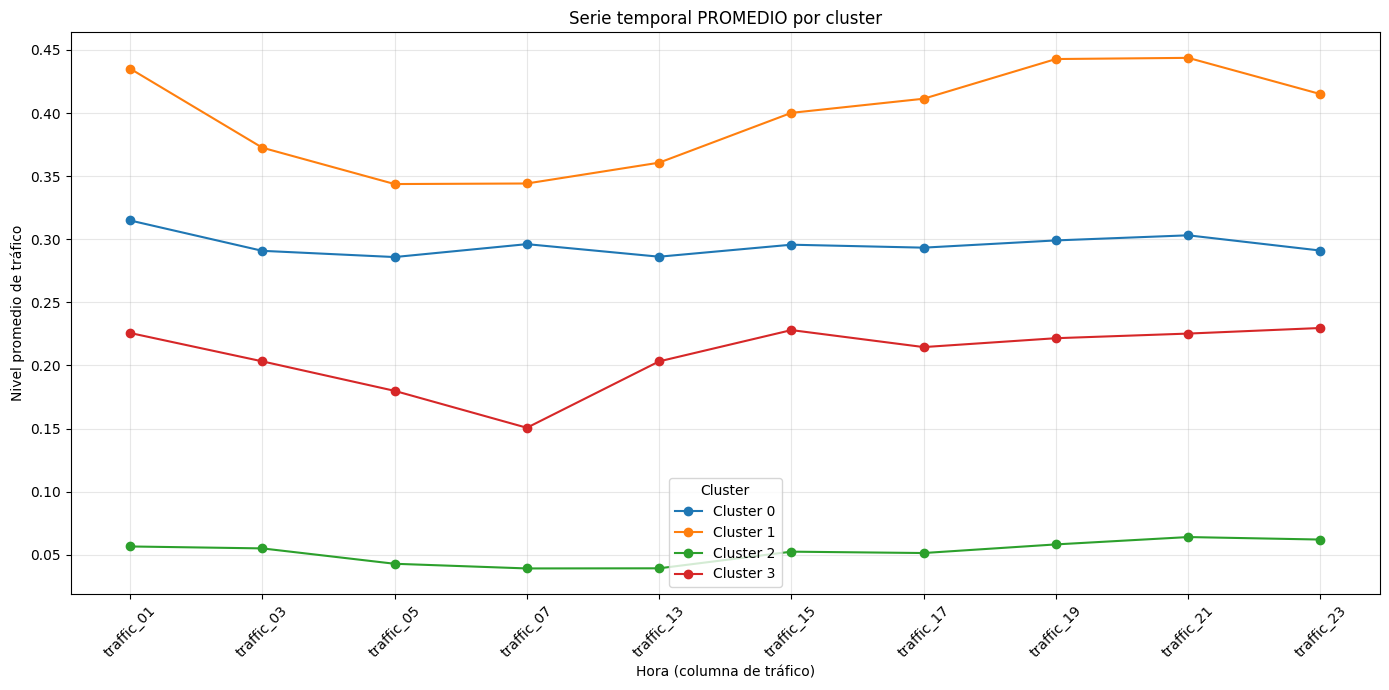

In [12]:
plt.figure(figsize=(14, 7))

x = list(range(len(TRAFFIC_COLS)))
x_labels = TRAFFIC_COLS

for cluster_id, row in cluster_means.iterrows():
    plt.plot(
        x,
        row.values,
        marker="o",
        label=f"Cluster {cluster_id}"
    )

plt.xticks(ticks=x, labels=x_labels, rotation=45)
plt.title("Serie temporal PROMEDIO por cluster")
plt.xlabel("Hora (columna de tráfico)")
plt.ylabel("Nivel promedio de tráfico")
plt.grid(True, alpha=0.3)
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()


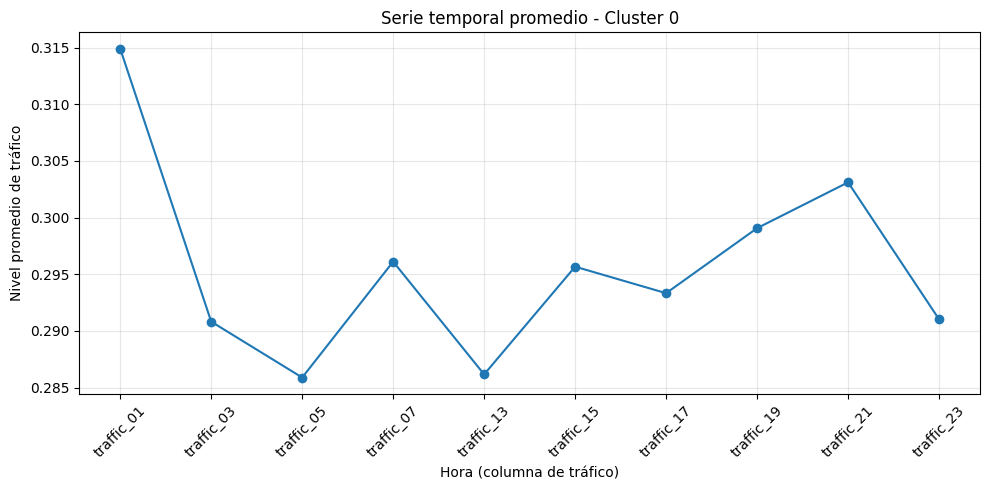

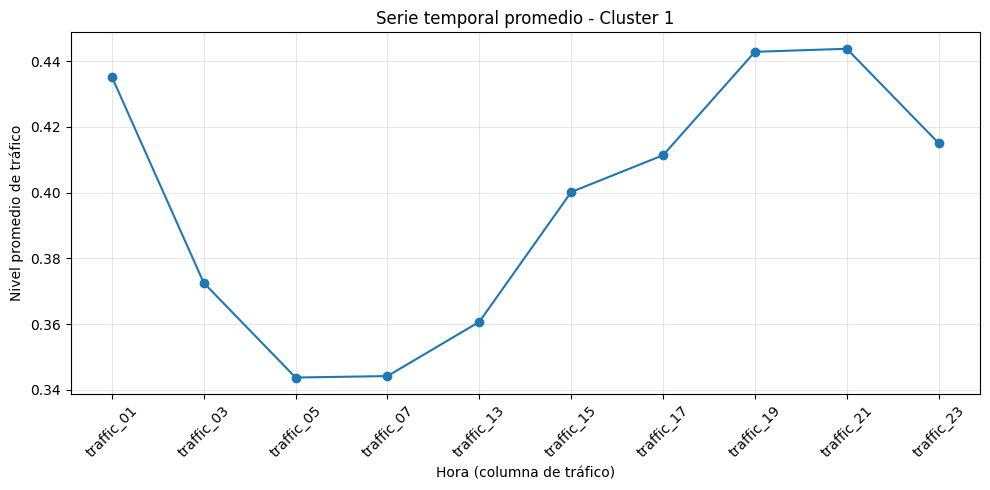

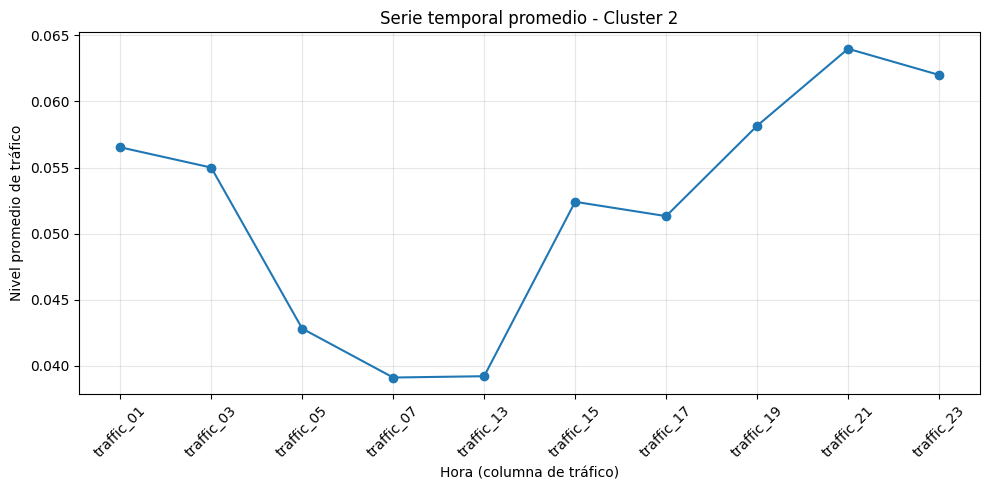

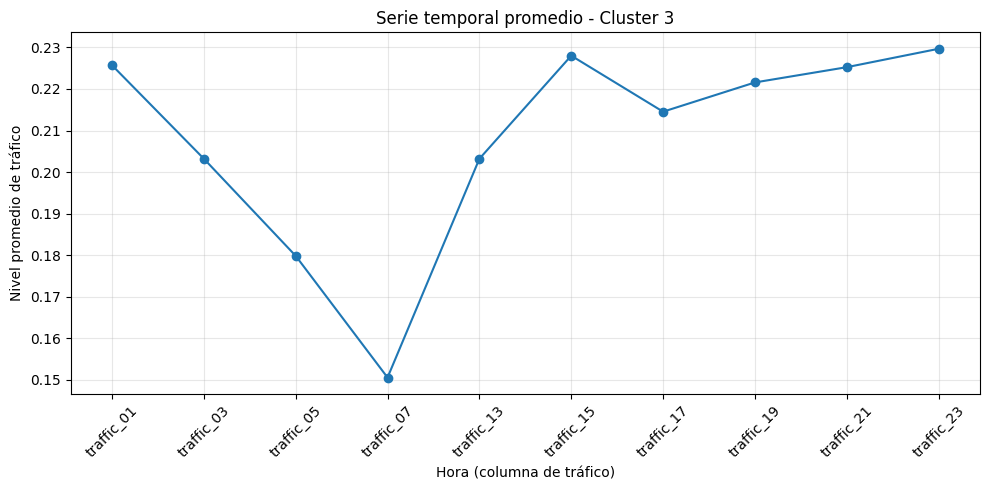

In [13]:
for cluster_id, row in cluster_means.iterrows():
    plt.figure(figsize=(10, 5))
    x = list(range(len(TRAFFIC_COLS)))
    plt.plot(x, row.values, marker="o")
    plt.xticks(ticks=x, labels=TRAFFIC_COLS, rotation=45)
    plt.title(f"Serie temporal promedio - Cluster {cluster_id}")
    plt.xlabel("Hora (columna de tráfico)")
    plt.ylabel("Nivel promedio de tráfico")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


In [14]:
import os

os.makedirs("figures_clusters", exist_ok=True)

for cluster_id, row in cluster_means.iterrows():
    plt.figure(figsize=(10, 5))
    x = list(range(len(TRAFFIC_COLS)))
    plt.plot(x, row.values, marker="o")
    plt.xticks(ticks=x, labels=TRAFFIC_COLS, rotation=45)
    plt.title(f"Serie temporal promedio - Cluster {cluster_id}")
    plt.xlabel("Hora (columna de tráfico)")
    plt.ylabel("Nivel promedio de tráfico")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    fname = os.path.join("figures_clusters", f"cluster_{cluster_id}.png")
    plt.savefig(fname, dpi=150)
    plt.close()
    print("Guardada figura:", fname)


Guardada figura: figures_clusters/cluster_0.png
Guardada figura: figures_clusters/cluster_1.png
Guardada figura: figures_clusters/cluster_2.png
Guardada figura: figures_clusters/cluster_3.png
